In [46]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [47]:
test_data = pd.read_csv(r'C:\Users\markham\OneDrive\Desktop\processed_articles.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data

,date,content
63,2022-12-01,"['russia', 'war', 'ukraine', 'latest', 'news',..."
820,2023-01-01,"['bank', 'korea', 'chief', 'see', 'conflict', ..."
740,2023-01-01,"['china', 'home', 'price', 'fall', 'faster', '..."
741,2023-01-01,"['augeraliassime', 'say', 'winning', 'momentum..."
742,2023-01-01,"['toneys', 'injury', 'significant', 'available..."
...,...,...
410,2023-01-04,"['gm', 'outsells', 'toyota', 'u', 'rise', 'aut..."
350,2023-01-05,"['inflation', 'drive', 'britain', 'record', 'c..."
87,2023-01-11,"['russia', 'war', 'ukraine', 'latest', 'russia..."
552,2023-01-18,"['argentine', 'artist', 'paint', 'inflationhit..."


In [48]:
# 训练 Word2Vec 模型
model = Word2Vec(sentences=test_data['content'], vector_size=50, window=5, min_count=1, workers=4)

# 定义一个函数，将文本转换为向量
def text_to_vector(text, model):
    vectors = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        # 如果文本中没有有效的词向量，返回全零向量
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))

In [49]:
# 提取所有新闻的向量数据
X = np.array(test_data['vector'].tolist())

# 假设聚类数量为 2，可根据实际情况调整
num_clusters = 3

# 创建 KMeans 模型
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 进行聚类
labels = kmeans.fit_predict(X)

# 将聚类标签添加到原数据中
test_data['cluster_label'] = labels
test_data


,date,content,vector,cluster_label
63,2022-12-01,"['russia', 'war', 'ukraine', 'latest', 'news',...","[-0.0063503818, -0.079458326, 0.18617637, 0.24...",2
820,2023-01-01,"['bank', 'korea', 'chief', 'see', 'conflict', ...","[-0.009457414, -0.09247988, 0.17981699, 0.2287...",2
740,2023-01-01,"['china', 'home', 'price', 'fall', 'faster', '...","[-0.018522272, -0.0925693, 0.20833279, 0.24871...",1
741,2023-01-01,"['augeraliassime', 'say', 'winning', 'momentum...","[-0.014066988, -0.0770308, 0.19284615, 0.25109...",2
742,2023-01-01,"['toneys', 'injury', 'significant', 'available...","[-0.029213708, -0.07373831, 0.2010394, 0.24009...",0
...,...,...,...,...
410,2023-01-04,"['gm', 'outsells', 'toyota', 'u', 'rise', 'aut...","[-0.046572633, -0.05003747, 0.20819534, 0.2413...",0
350,2023-01-05,"['inflation', 'drive', 'britain', 'record', 'c...","[-0.020011054, -0.08791612, 0.19900732, 0.2553...",1
87,2023-01-11,"['russia', 'war', 'ukraine', 'latest', 'russia...","[-0.010523725, -0.08148647, 0.20199876, 0.2496...",2
552,2023-01-18,"['argentine', 'artist', 'paint', 'inflationhit...","[-0.01778588, -0.08826845, 0.19320826, 0.25230...",2


In [50]:
# 评估聚类效果
if len(set(labels)) > 1:
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"轮廓系数: {silhouette}")
    print(f"Calinski - Harabasz 指数: {ch_score}")
else:
    print("由于簇的数量不大于 1，无法计算聚类评估指标。")


轮廓系数: 0.12001153081655502
Calinski - Harabasz 指数: 115.4971671310276


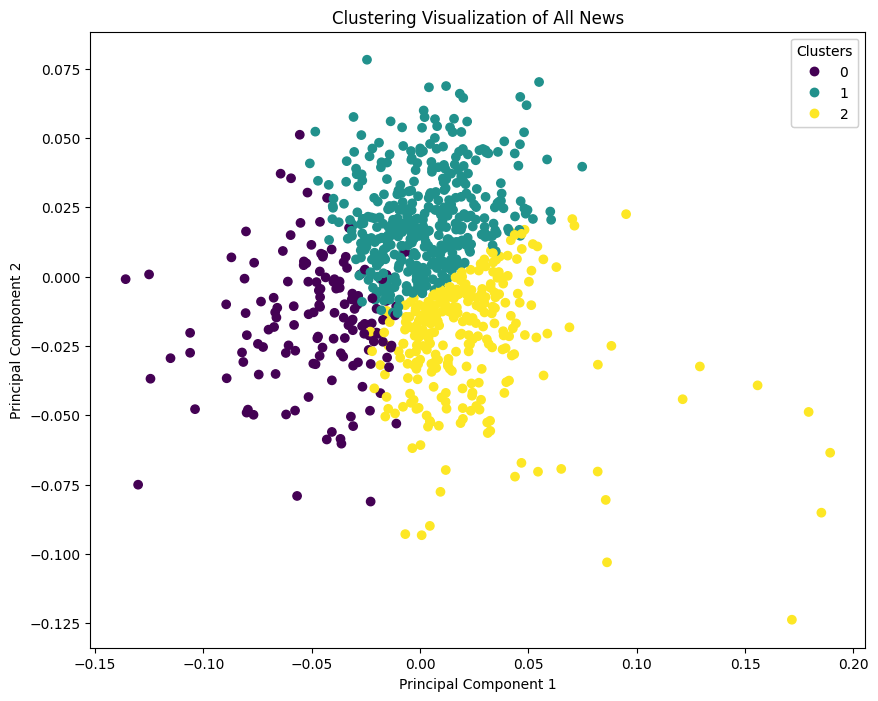

In [51]:
# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title('Clustering Visualization of All News')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [52]:
# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])

# 按日期分组
grouped = test_data.groupby('date')

# 加载 FinBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# 存储每天每个聚类的情感指数结果
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        for content in cluster_data['content']:
            text = " ".join(content)
            try:
                # 截断和填充文本
                inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
                outputs = model(**inputs)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=1)
                # 情感得分：积极概率 - 消极概率
                sentiment_score = probabilities[0][0].item() - probabilities[0][2].item()
                sentiment_scores.append(sentiment_score)
            except Exception as e:
                print(f"处理文本时出错: {text}，错误信息: {e}")
                continue
        if sentiment_scores:
            average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        else:
            average_sentiment = 0
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
           'sentiment_score': average_sentiment
        })

# 创建包含情感分析结果的 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

print(sentiment_df)

         date  cluster  sentiment_score
0  2022-12-01        0         0.000000
1  2022-12-01        1         0.000000
2  2022-12-01        2        -0.896649
3  2023-01-01        0        -0.893593
4  2023-01-01        1        -0.892829
5  2023-01-01        2        -0.892321
6  2023-01-02        0        -0.890959
7  2023-01-02        1        -0.892629
8  2023-01-02        2        -0.892941
9  2023-01-03        0        -0.891217
10 2023-01-03        1        -0.892687
11 2023-01-03        2        -0.892132
12 2023-01-04        0        -0.892201
13 2023-01-04        1        -0.892219
14 2023-01-04        2        -0.892488
15 2023-01-05        0         0.000000
16 2023-01-05        1        -0.891887
17 2023-01-05        2         0.000000
18 2023-01-11        0         0.000000
19 2023-01-11        1         0.000000
20 2023-01-11        2        -0.893231
21 2023-01-18        0         0.000000
22 2023-01-18        1         0.000000
23 2023-01-18        2        -0.892953
